# Calculus of Variations Basic example

In [8]:
from os.path import exists
file_exists = exists('basic_material.py')

if (not file_exists):
  !wget -O basic_material.py https://www.dropbox.com/s/3aoexl8vxyitmds/basic_material.py?dl=0
%run basic_material

if not shutil.which("pyomo"):
    !pip install -q pyomo
    assert(shutil.which("pyomo"))

if not (shutil.which("ipopt") or os.path.isfile("ipopt")):
    if "google.colab" in sys.modules:
        !wget -N -q "https://ampl.com/dl/open/ipopt/ipopt-linux64.zip"
        !unzip -o -q ipopt-linux64
    else:
        try:
            !conda install -c conda-forge ipopt 
        except:
            pass

assert(shutil.which("ipopt") or os.path.isfile("ipopt"))
from pyomo.environ import *
from pyomo.dae import *

Running Python: 3.8.12


$$
\min_{x(t)} \int_0^1 0.5\dot x(t)^2+3x(t)\dot x(t)+2x(t)^2 + 4x(t) ~dt
$$
given $x(0)=1$ and $x(1)=5$

In [9]:
m = ConcreteModel()
m.t = ContinuousSet(bounds=(0,1))

m.x = Var(m.t)
m.g = Var(m.t)
m.xdot = DerivativeVar(m.x,wrt=m.t)
m.x[0].fix(1)
m.x[1].fix(5)

# incscribed in ellipse constraint
m.c = Constraint(m.t, rule=lambda m, t: - m.g[t] + 0.5*m.xdot[t]**2+3*m.x[t]*m.xdot[t]+2*m.x[t]**2 + 4*m.x[t] == 0)

def _intX(m,t):
    return m.g[t]
m.intX = Integral(m.t, wrt = m.t, rule = _intX)

m.obj = Objective(expr = m.intX, sense=minimize)

TransformationFactory('dae.finite_difference').apply_to(m, wrt=m.t, nfe=1000)

solver = SolverFactory('ipopt', keepfiles=True, log_file='log', soln_file='sol')
#solver.options['linear_solver']      = 'ma97'

results = solver.solve(m)
print(results.solver.status)
print(results.solver.termination_condition)

ok
optimal


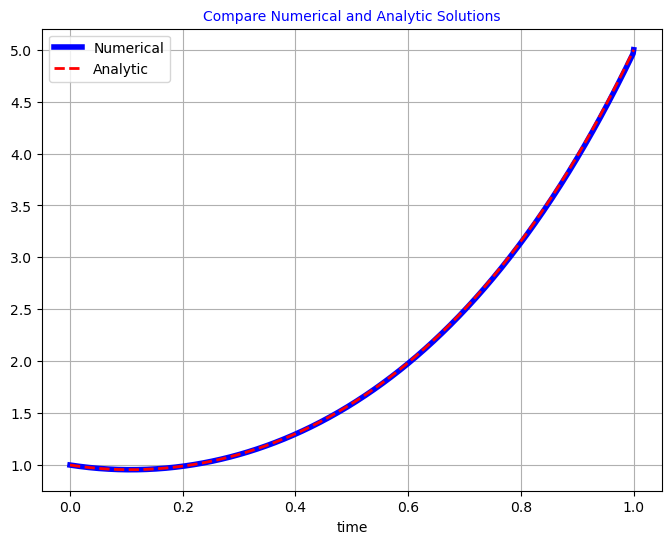

In [10]:
# access the results
tt = np.array([t for t in m.t])
x = np.array([m.x[t]() for t in m.t])

x_analytic = 0.7898*np.exp(2*tt) + 1.210*np.exp(-2*tt) -1

plt.figure(figsize=(8,6))
plt.plot(tt,x, 'b-',lw=4,label='Numerical')
plt.plot(tt, x_analytic, 'r--',lw=2,label='Analytic')
plt.title('Compare Numerical and Analytic Solutions')
plt.xlabel('time')
plt.grid(True)
plt.legend()
plt.savefig('./figs/CoV_example2.png')
plt.show()